# Tasks

We will implement a coupling flow like RealNVP/Glow  and fit it to 2D toy data.

### *Todo*:
1. Implement the `Coupling` bijection class
1. Implement the `make_net` function
1. Train flow and sample
1. **Bonus:** Study the effect of some parameter (e.g. flow layers, NN layers, NN dim, NN activation, etc.) and improve performance.

# Create Dataset

In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TwoSpirals(Dataset):
    def __init__(self, num_points):
        self.num_points = num_points
        self._create_data()

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return self.num_points

    def _create_data(self):
        n = torch.sqrt(torch.rand(self.num_points // 2)) * 540 * (2 * np.pi) / 360
        d1x = -torch.cos(n) * n + torch.rand(self.num_points // 2) * 0.5
        d1y = torch.sin(n) * n + torch.rand(self.num_points // 2) * 0.5
        x = torch.cat([torch.stack([d1x, d1y]).t(), torch.stack([-d1x, -d1y]).t()])
        self.data = x / 3 + torch.randn_like(x) * 0.1

n_dim = 2
n_obs = 128000
batch_size = 128

train_loader = DataLoader(TwoSpirals(n_obs), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TwoSpirals(n_obs), batch_size=batch_size, shuffle=False)

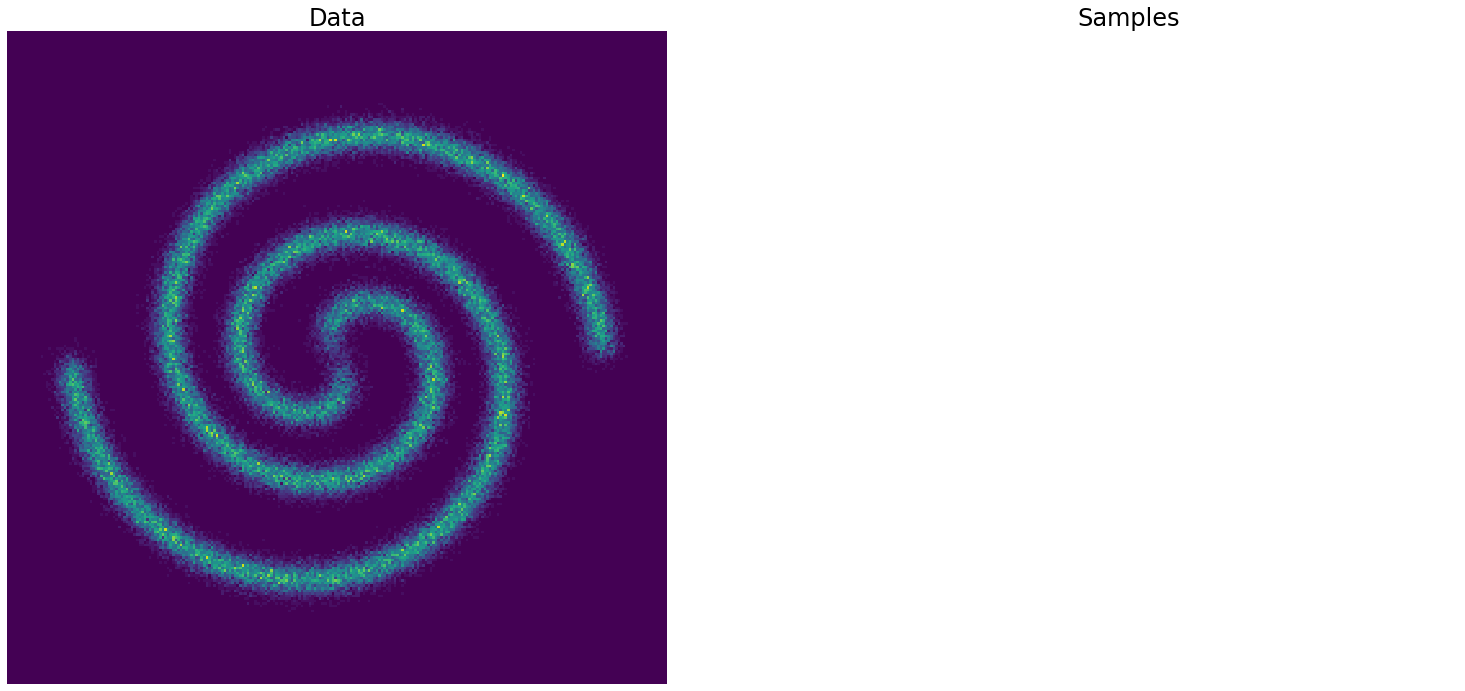

In [114]:
import matplotlib.pyplot as plt

def plot_samples(s=None):
  d = test_loader.dataset.data.numpy()
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 12))
  ax[0].axis('off'); ax[1].axis('off')
  ax[0].set_title('Data', fontsize=24); ax[1].set_title('Samples', fontsize=24)
  ax[0].hist2d(d[...,0], d[...,1], bins=256, range=[[-4, 4], [-4, 4]])
  if s is not None:
    s = s.detach().cpu().numpy()
    ax[1].hist2d(s[...,0], s[...,1], bins=256, range=[[-4, 4], [-4, 4]])
  plt.show()

plot_samples()

# Create Model

In [115]:
import torch
from torch import nn
from torch.distributions import Normal


class Flow(nn.Module):

    def __init__(self, bijections):
        super().__init__()
        self.bijections = nn.ModuleList(bijections)

    @property
    def base_dist(self):
        return Normal(
            loc=torch.zeros(2, device=device),
            scale=torch.ones(2, device=device),
        )

    def log_prob(self, x):
        log_prob = torch.zeros(x.shape[0], device=device)
        for bijection in self.bijections:
            x, ldj = bijection(x)
            log_prob += ldj
        log_prob += self.base_dist.log_prob(x).sum(1)
        return log_prob

    def sample(self, num_samples):
        with torch.no_grad():
            z = self.base_dist.sample((num_samples,))
            for bijection in reversed(self.bijections):
                z = bijection.inverse(z)
        return z


In [116]:
# Implement Bijections

class Reverse(nn.Module):

    def forward(self, x):
        return x.flip(-1), x.new_zeros(x.shape[0])

    def inverse(self, z):
        return z.flip(-1)


class Coupling(nn.Module):
  
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        '''TODO: Implement z<-x transformation and ldj (log determinant Jacobian)'''

        ## Latent:
        # Chunks
        z_0, x_1 = torch.chunk(x, 2,dim=-1) 
        p = self.net(z_0)
        alpha, mu = torch.chunk(p,2,dim=-1)
        z_1 = (x_1 * alpha.exp()) + mu
        z = torch.cat([z_0, z_1],dim=-1)

        # Jacobian determinant:
        ldj = alpha.sum(-1)

        return z, ldj

    def inverse(self, z):
        '''TODO: Implement x<-z transformation'''

        with torch.no_grad():
            # Chunks
            x_0, z_1 = torch.chunk(z, 2, dim=-1)
            p = self.net(x_0)
            alpha, mu = torch.chunk(p,2,dim=-1)
            # Transform x_1
            x_1 = (z_1 - mu) * (-alpha).exp()
            x = torch.cat([x_0, x_1], dim=-1)

        return x

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_hidden = 50
activation = torch.nn.GELU()

def make_net():
  net = torch.nn.Sequential(
    torch.nn.Linear(1,n_hidden), activation,
    torch.nn.Linear(n_hidden,n_hidden*2), activation,
    torch.nn.Linear(n_hidden*2,2)
  )
  return net 

flow = Flow([
  Coupling(make_net()), Reverse(),
  Coupling(make_net()), Reverse(),
  Coupling(make_net()), Reverse(),
  Coupling(make_net()),
]).to(device)

print(flow)

Flow(
  (bijections): ModuleList(
    (0): Coupling(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=50, bias=True)
        (1): GELU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): GELU()
        (4): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (1): Reverse()
    (2): Coupling(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=50, bias=True)
        (1): GELU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): GELU()
        (4): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (3): Reverse()
    (4): Coupling(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=50, bias=True)
        (1): GELU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): GELU()
        (4): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (5): Reverse()
    (6): Coupling(
      (net): Sequent

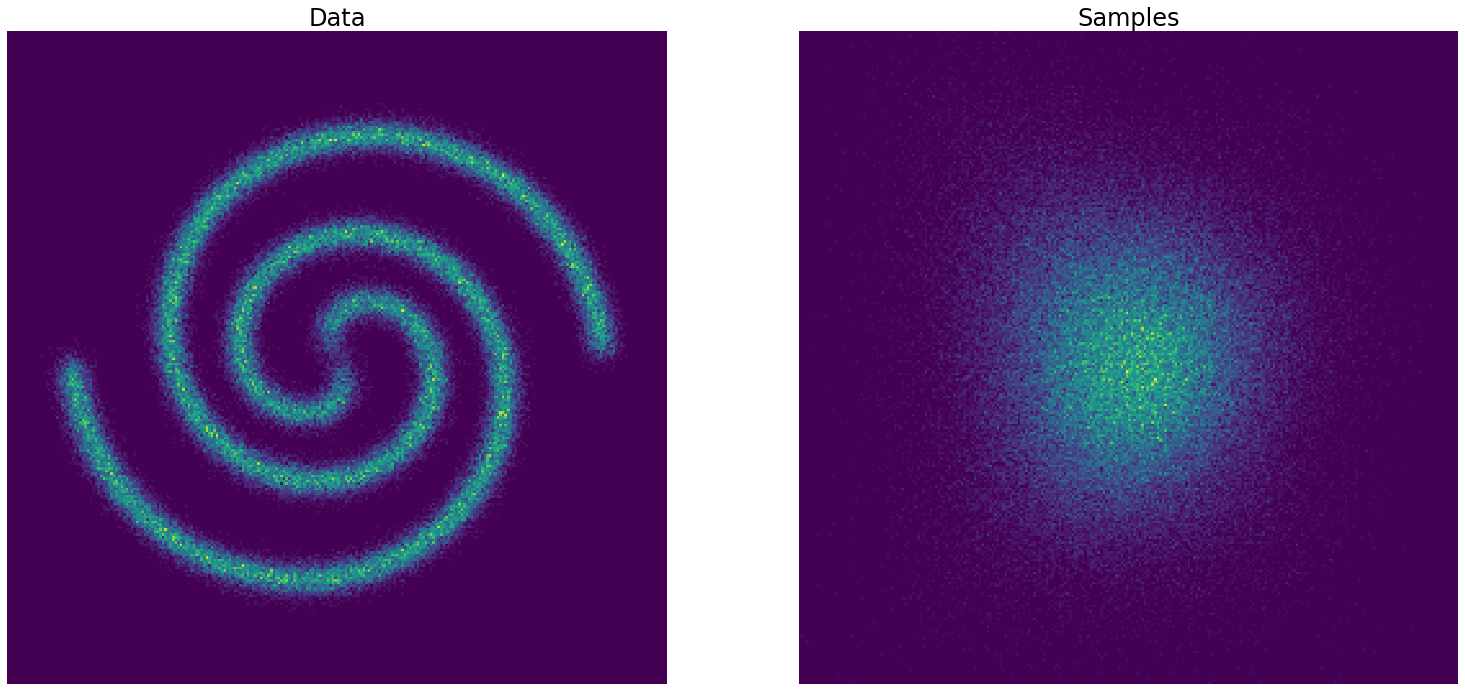

In [118]:
# Plot model samples at initialization
plot_samples(flow.sample(n_obs))

# Train model

In [137]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 100

print('Training...')
flow = flow.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        loss = -flow.log_prob(x).mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_loader)))
flow = flow.eval()

Training...
Epoch: 1/100, Loss: 3.400
Epoch: 2/100, Loss: 3.146
Epoch: 3/100, Loss: 3.098
Epoch: 4/100, Loss: 3.083
Epoch: 5/100, Loss: 3.081
Epoch: 6/100, Loss: 3.080
Epoch: 7/100, Loss: 3.072
Epoch: 8/100, Loss: 3.071
Epoch: 9/100, Loss: 3.060
Epoch: 10/100, Loss: 3.061
Epoch: 11/100, Loss: 3.054
Epoch: 12/100, Loss: 3.056
Epoch: 13/100, Loss: 3.051
Epoch: 14/100, Loss: 3.048
Epoch: 15/100, Loss: 3.044


KeyboardInterrupt: 

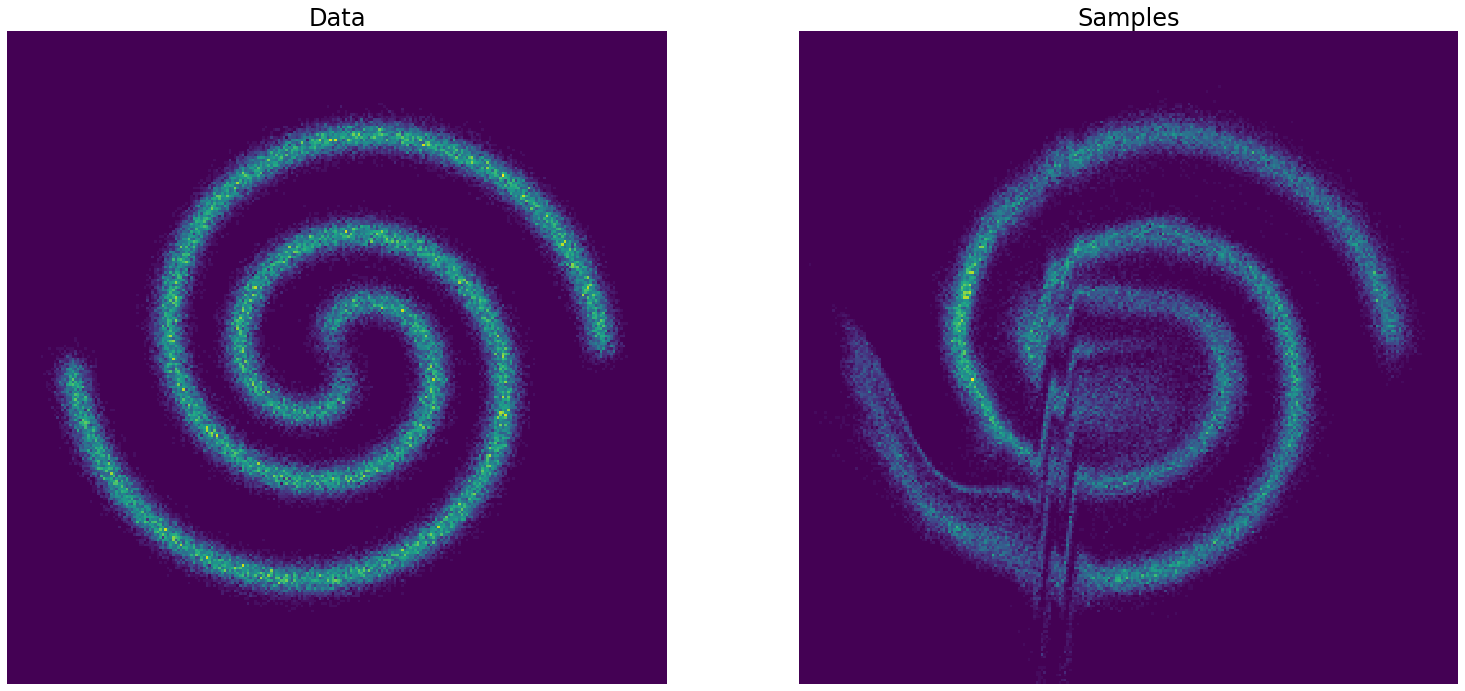

In [135]:
# Plot model samples after training
plot_samples(flow.sample(n_obs))